In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf
tf.keras.utils.set_random_seed(3)
from tqdm import tqdm

In [2]:
from tensorflow.keras.utils import plot_model
import time

# Data

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# train_path = "/content/drive/MyDrive/Cursos/TFM_AI/TFM/aplicacion/data/train.npz"
# test_path = "/content/drive/MyDrive/Cursos/TFM_AI/TFM/aplicacion/data/test.npz"
# model_path = "/content/drive/MyDrive/Cursos/TFM_AI/TFM/aplicacion/models/vq_vae.h5"
# pixelcnn_model_path = "/content/drive/MyDrive/Cursos/TFM_AI/TFM/aplicacion/models/vq_vae_pixelcnn.h5"

train_path = "data/train.npz"
test_path = "data/test.npz"
model_path = "models/vq_vae.h5"
pixelcnn_model_path = "models/vq_vae_pixelcnn.h5"


In [5]:
train_data = np.load(train_path)
X_train = train_data["arr_0"]
y_train = train_data["arr_1"]
X_train.shape, y_train.shape

((10000, 128, 128, 1), (10000,))

In [6]:
test_data = np.load(test_path)
X_test = test_data["arr_0"]
y_test = test_data["arr_1"]
X_test.shape, y_test.shape

((400, 128, 128, 1), (400,))

In [7]:
X_train = X_train / 255.
X_test = X_test / 255.

# Model

## Encoder

In [8]:
latent_dim = 8
num_embeddings=16

In [9]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened) #aquí calcula el punto más cercano del embedding al x
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        codebook_indices = tf.reshape(encoding_indices, input_shape[:-1])

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized, codebook_indices

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices
    
    def quantize_from_priors(self, priors): #is will be used for generation with pixelcnn
        priors_ohe = tf.one_hot(priors.astype("int32"), self.num_embeddings).numpy()
        quantized = tf.matmul(priors_ohe.astype("float32"), self.embeddings, transpose_b=True)
        return np.squeeze(quantized)
    
    def get_config(self): #Need this part to be able to save in .h5
        config = super().get_config() #.copy()
        config.update({
            'num_embeddings': self.num_embeddings,
            'embedding_dim': self.embedding_dim,
            'beta': self.beta
        })
        return config

In [10]:
def get_encoder(latent_dim=16, input_shape=(128,128,1)):
    encoder_inputs = keras.Input(shape=input_shape)
    x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
    x = tf.add(x, x1)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x = tf.add(x, x1)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x = tf.add(x, x1)
    x = layers.BatchNormalization()(x)
#    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x1)
    x = tf.add(x, x1)
    x = layers.BatchNormalization()(x)
#    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")
get_encoder(latent_dim).summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                           

In [11]:
def get_decoder(latent_dim=16, image_dim=(128, 128, 1)):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim, image_dim).output.shape[1:])
    
    x1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(latent_inputs)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x1)
    x = tf.add(x, x1)
    x = layers.BatchNormalization()(x)
#     x = layers.UpSampling2D((2, 2))(x)

    x1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x = tf.add(x, x1)
    x = layers.BatchNormalization()(x)
#     x = layers.UpSampling2D((2, 2))(x)

    x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x = tf.add(x, x1)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)

    x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
    x = tf.add(x, x1)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    decoder_outputs = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

get_decoder(latent_dim).summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 8)]  0           []                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 32, 32, 256)  18688       ['input_3[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 32, 32, 256)  590080      ['conv2d_18[0][0]']              
                                                                                                  
 tf.math.add_8 (TFOpLambda)     (None, 32, 32, 256)  0           ['conv2d_19[0][0]',              
                                                                  'conv2d_18[0][0]']        

In [12]:
def get_vqvae(latent_dim=16, num_embeddings=64, img_shape=(128,128,1)):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim, img_shape)
    decoder = get_decoder(latent_dim, img_shape)
    
    inputs = keras.Input(shape=img_shape)
    encoder_outputs = encoder(inputs)
    quantized_latents, codebook_indices = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, [reconstructions, codebook_indices], name="vq_vae")
get_vqvae(latent_dim, num_embeddings).summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 encoder (Functional)        (None, 32, 32, 8)         1175656   
                                                                 
 vector_quantizer (VectorQua  ((None, 32, 32, 8),      128       
 ntizer)                      (None, 32, 32))                    
                                                                 
 decoder (Functional)        (None, 128, 128, 1)       1192033   
                                                                 
Total params: 2,367,817
Trainable params: 2,365,897
Non-trainable params: 1,920
_________________________________________________________________


In [13]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, img_shape=(128,128,1), **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings, img_shape)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions, _ = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "r_loss": self.reconstruction_loss_tracker.result(),
            "vq_loss": self.vq_loss_tracker.result(),
        }
    
    def test_step(self, x):
        reconstructions, _ = self.vqvae(x)
        # Calculate the losses.
        reconstruction_loss = (
            tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
        )
        total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "r_loss": self.reconstruction_loss_tracker.result(),
            "vq_loss": self.vq_loss_tracker.result(),
        }

In [14]:
data_variance = np.var(X_train)

In [15]:
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0005, patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

vqvae_trainer = VQVAETrainer(data_variance, latent_dim=latent_dim, num_embeddings=num_embeddings)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam(0.001))

In [16]:
init_time = time.time()
logs = vqvae_trainer.fit(X_train, epochs=100, batch_size=32, 
               validation_data=(X_test, None), 
               callbacks=[early_stop, reduce_lr])
print(f"Total time: {time.time() - init_time} (s)")

Epoch 1/100
313/313 [==============================] - 39s 103ms/step - loss: 9.8050 - r_loss: 0.5485 - vq_loss: 6.8955 - val_loss: 1.4628 - val_r_loss: 0.1115 - val_vq_loss: 1.3513 - lr: 0.0010
Epoch 2/100
313/313 [==============================] - 31s 98ms/step - loss: 1.3670 - r_loss: 0.1325 - vq_loss: 0.7090 - val_loss: 0.1387 - val_r_loss: 0.0582 - val_vq_loss: 0.0805 - lr: 0.0010
Epoch 3/100
313/313 [==============================] - 30s 97ms/step - loss: 0.1749 - r_loss: 0.0729 - vq_loss: 0.0945 - val_loss: 0.3010 - val_r_loss: 0.0507 - val_vq_loss: 0.2503 - lr: 0.0010
Epoch 4/100
313/313 [==============================] - 30s 97ms/step - loss: 0.1164 - r_loss: 0.0619 - vq_loss: 0.0505 - val_loss: 0.0961 - val_r_loss: 0.0409 - val_vq_loss: 0.0551 - lr: 0.0010
Epoch 5/100
313/313 [==============================] - 30s 97ms/step - loss: 0.0977 - r_loss: 0.0566 - vq_loss: 0.0392 - val_loss: 0.0680 - val_r_loss: 0.0395 - val_vq_loss: 0.0285 - lr: 0.0010
Epoch 6/100
313/313 [========

In [17]:
vae = vqvae_trainer.vqvae

In [18]:
vae.save(model_path)

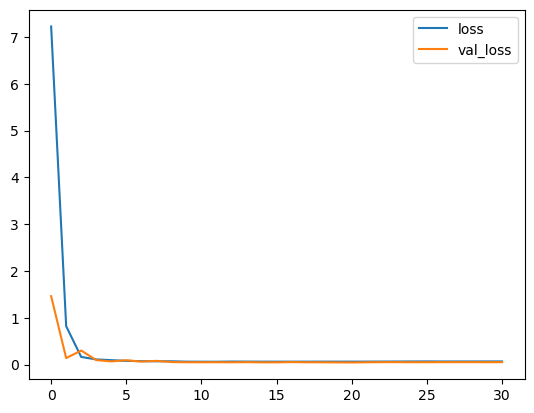

In [19]:
plt.plot(logs.history['loss'], label="loss")
plt.plot(logs.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

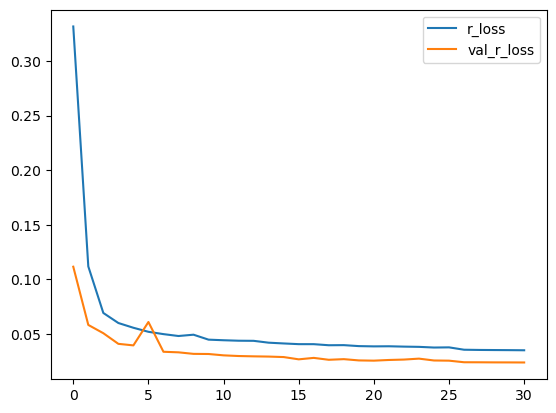

In [20]:
plt.plot(logs.history['r_loss'], label="r_loss")
plt.plot(logs.history['val_r_loss'], label="val_r_loss")
plt.legend()
plt.show()

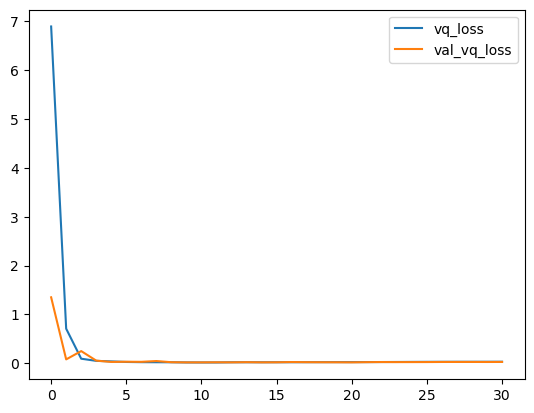

In [21]:
plt.plot(logs.history['vq_loss'], label="vq_loss")
plt.plot(logs.history['val_vq_loss'], label="val_vq_loss")
plt.legend()
plt.show()

# Testing

In [22]:
# optional
vae = keras.models.load_model(model_path, custom_objects={'VectorQuantizer': VectorQuantizer}, compile=False)
vae.summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 encoder (Functional)        (None, 32, 32, 8)         1175656   
                                                                 
 vector_quantizer (VectorQua  ((None, 32, 32, 8),      128       
 ntizer)                      (None, 32, 32))                    
                                                                 
 decoder (Functional)        (None, 128, 128, 1)       1192033   
                                                                 
Total params: 2,367,817
Trainable params: 2,365,897
Non-trainable params: 1,920
_________________________________________________________________


13/13 [==============================] - 1s 29ms/step


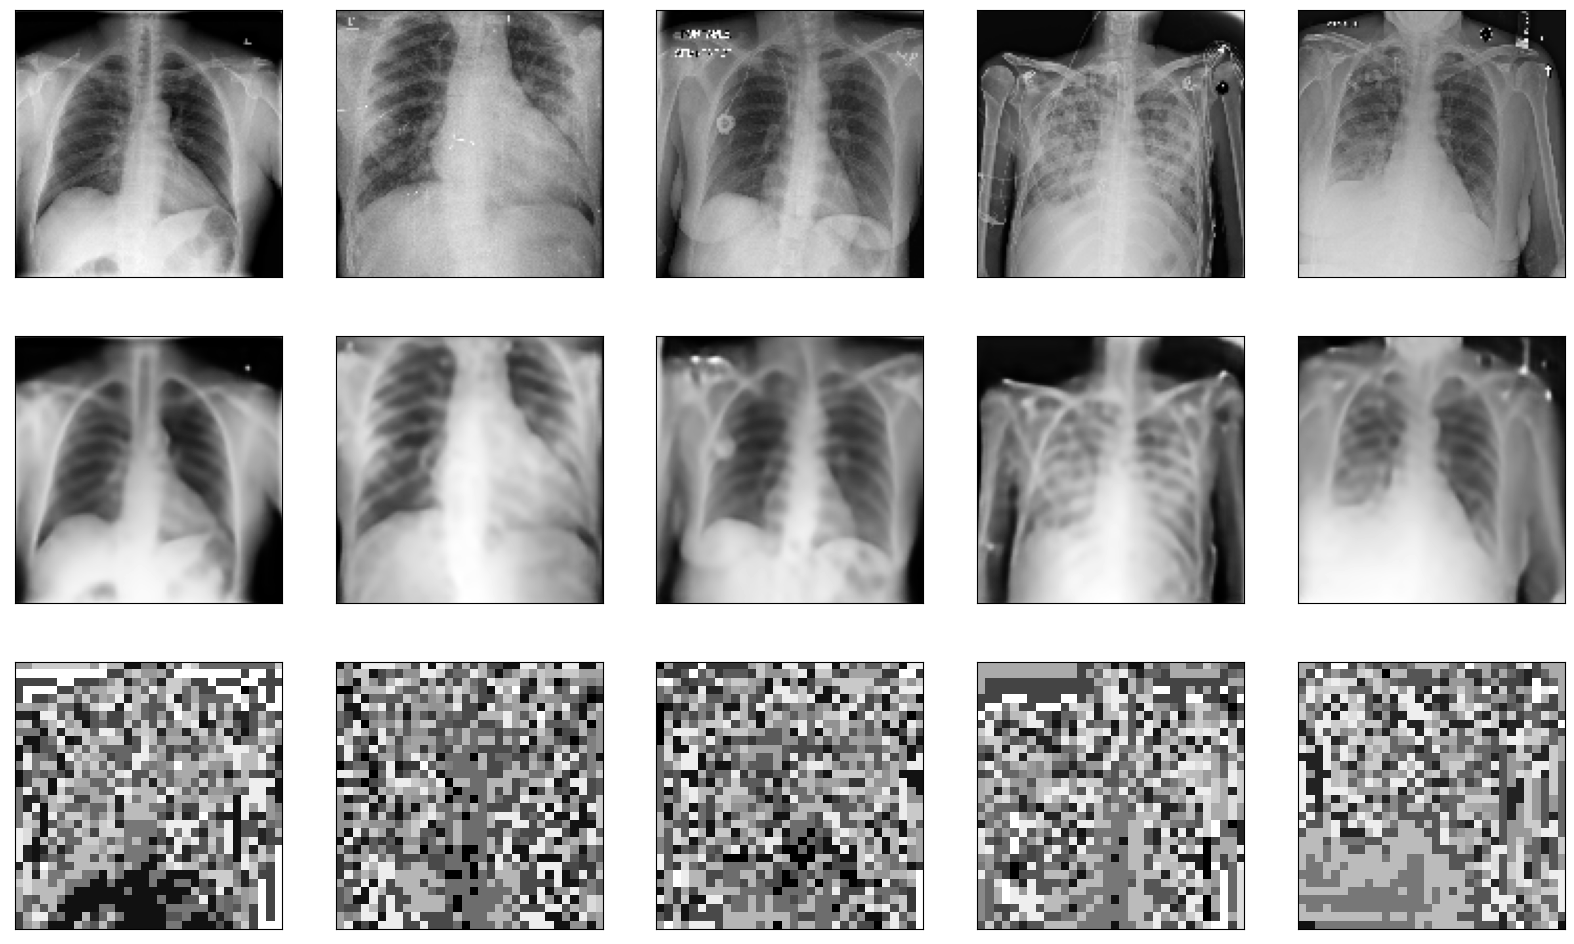

In [23]:
decoded_imgs, test_prior = vae.predict(X_test)

n = 5
plt.figure(figsize=(20, 12))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(3, n, i)
    plt.imshow(X_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display prior
    ax = plt.subplot(3, n, i + n*2)
    plt.imshow(test_prior[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Sampling images

In [24]:
"""
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")
decoder = vqvae_trainer.vqvae.get_layer("decoder")
"""
encoder = vae.get_layer("encoder")
quantizer = vae.get_layer("vector_quantizer")
decoder = vae.get_layer("decoder")

In [25]:
_, codebook_indices = vae.predict(X_train)

313/313 [==============================] - 9s 28ms/step


In [26]:
num_residual_blocks = 5
num_pixelcnn_layers = 2
pixelcnn_input_shape = codebook_indices.shape[1:]
print(f"Input shape of the PixelCNN: {pixelcnn_input_shape}")

Input shape of the PixelCNN: (32, 32)


In [27]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, filters, kernel_size=3, activation=None, padding="valid", **kwargs):
        super().__init__(**kwargs)
        self.mask_type = mask_type
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation
        self.padding = padding
        self.conv = layers.Conv2D(self.filters, kernel_size=kernel_size, activation=activation, padding=padding)

    def build(self, input_shape): #override 
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs): #override 
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)
    
    #override 
    def get_config(self): #in order to be able to save and load
        config = super().get_config()
        config.update({
            "mask_type": self.mask_type,
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            "activation": self.activation,
            "padding": self.padding
        })
        return config


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters,
        })
        return config

In [29]:
pixelcnn_inputs = keras.Input(shape=pixelcnn_input_shape, dtype=tf.uint8)
ohe = tf.one_hot(pixelcnn_inputs, vqvae_trainer.num_embeddings)
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(ohe)

label_input = layers.Input(shape=())
x_cond = layers.Embedding(2, np.prod(pixelcnn_input_shape), input_length=1)(label_input) #classes=2
x_cond = layers.Reshape(pixelcnn_input_shape+(1,))(x_cond)
x_cond = tf.repeat(x_cond, 128, axis=-1)

x = keras.layers.Concatenate()([x, x_cond])
for _ in range(num_residual_blocks):
    x = ResidualBlock(filters=256)(x)

for _ in range(num_pixelcnn_layers):
    x = PixelConvLayer(
        mask_type="B",
        filters=256,
        kernel_size=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(
    filters=vqvae_trainer.num_embeddings, kernel_size=1, strides=1, padding="valid"
)(x)

pixel_cnn = keras.Model([pixelcnn_inputs, label_input], out, name="pixel_cnn")
pixel_cnn.summary()

Model: "pixel_cnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 32, 32)]     0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1024)         2048        ['input_15[0][0]']               
                                                                                                  
 tf.one_hot_1 (TFOpLambda)      (None, 32, 32, 16)   0           ['input_14[0][0]']               
                                                                                          

In [30]:
pixel_cnn.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [31]:
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0005, patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

In [32]:
history = pixel_cnn.fit(
    x=[codebook_indices, y_train],
    y=codebook_indices,
    batch_size=32,
    epochs=100,
    validation_data=([test_prior, y_test], test_prior),
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/100
313/313 [==============================] - 19s 58ms/step - loss: 1.7822 - accuracy: 0.3417 - val_loss: 1.5425 - val_accuracy: 0.4028 - lr: 0.0010
Epoch 2/100
313/313 [==============================] - 18s 57ms/step - loss: 1.5923 - accuracy: 0.3945 - val_loss: 1.4697 - val_accuracy: 0.4248 - lr: 0.0010
Epoch 3/100
313/313 [==============================] - 18s 57ms/step - loss: 1.5439 - accuracy: 0.4084 - val_loss: 1.4393 - val_accuracy: 0.4328 - lr: 0.0010
Epoch 4/100
313/313 [==============================] - 18s 58ms/step - loss: 1.5192 - accuracy: 0.4157 - val_loss: 1.4157 - val_accuracy: 0.4403 - lr: 0.0010
Epoch 5/100
313/313 [==============================] - 18s 58ms/step - loss: 1.5012 - accuracy: 0.4209 - val_loss: 1.4042 - val_accuracy: 0.4445 - lr: 0.0010
Epoch 6/100
313/313 [==============================] - 18s 58ms/step - loss: 1.4899 - accuracy: 0.4242 - val_loss: 1.4011 - val_accuracy: 0.4452 - lr: 0.0010
Epoch 7/100
313/313 [==============================]

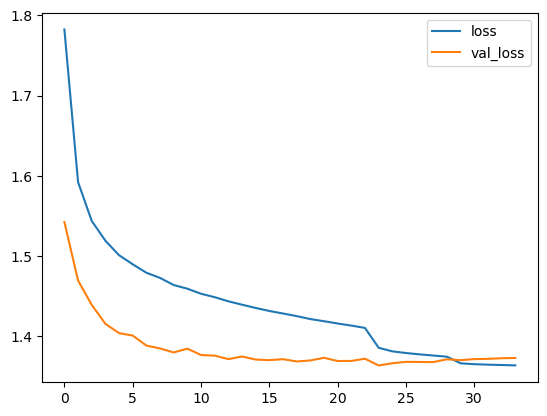

In [33]:
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

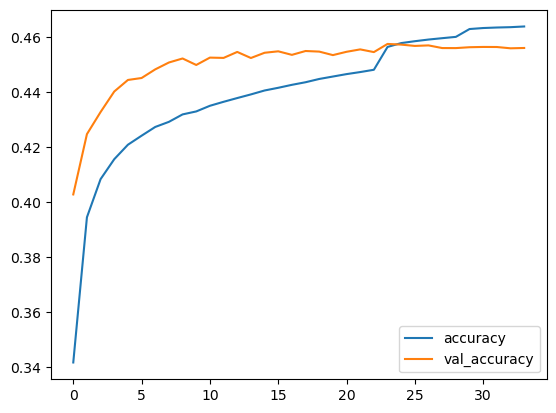

In [34]:
plt.plot(history.history['accuracy'], label="accuracy")
plt.plot(history.history['val_accuracy'], label="val_accuracy")
plt.legend()
plt.show()

In [35]:
pixel_cnn.save(pixelcnn_model_path)

In [36]:
#optional
pixel_cnn = keras.models.load_model(pixelcnn_model_path, 
                                    custom_objects={"PixelConvLayer": PixelConvLayer, 
                                                    "ResidualBlock":ResidualBlock})

In [37]:
# Create a mini sampler model.
inputs = layers.Input(shape=pixelcnn_input_shape)
inputs_cond = layers.Input(shape=())
outputs = pixel_cnn([inputs, inputs_cond], training=False)

categorical_layer = tfp.layers.DistributionLambda(tfp.distributions.Categorical)
outputs = categorical_layer(outputs)
sampler = keras.Model([inputs, inputs_cond], outputs)

In [38]:
# Create an empty array of priors.
batch = 4
priors = np.zeros(shape=(batch,) + pixelcnn_input_shape)
batch, rows, cols = priors.shape

In [39]:
cond_inp = np.array([0,0,1,1])
cond_inp_str = np.where(cond_inp==0, "negative", "positive")
cond_inp_str

array(['negative', 'negative', 'positive', 'positive'], dtype='<U8')

In [40]:
# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in tqdm(range(rows)):
    for col in range(cols):
        # Feed the whole array and retrieving the pixel value probabilities for the next
        # pixel.
        probs = sampler.predict([np.expand_dims(priors,-1), cond_inp], verbose=0)
        # Use the probabilities to pick pixel values and append the values to the priors.
        probs = np.squeeze(probs)
        priors[:, row, col] = probs[:, row, col]

print(f"Prior shape: {priors.shape}")

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:02<00:00,  1.96s/it]

Prior shape: (4, 32, 32)


In [41]:
quantized = quantizer.quantize_from_priors(priors)
generated_samples = decoder.predict(quantized)

1/1 [==============================] - 0s 462ms/step


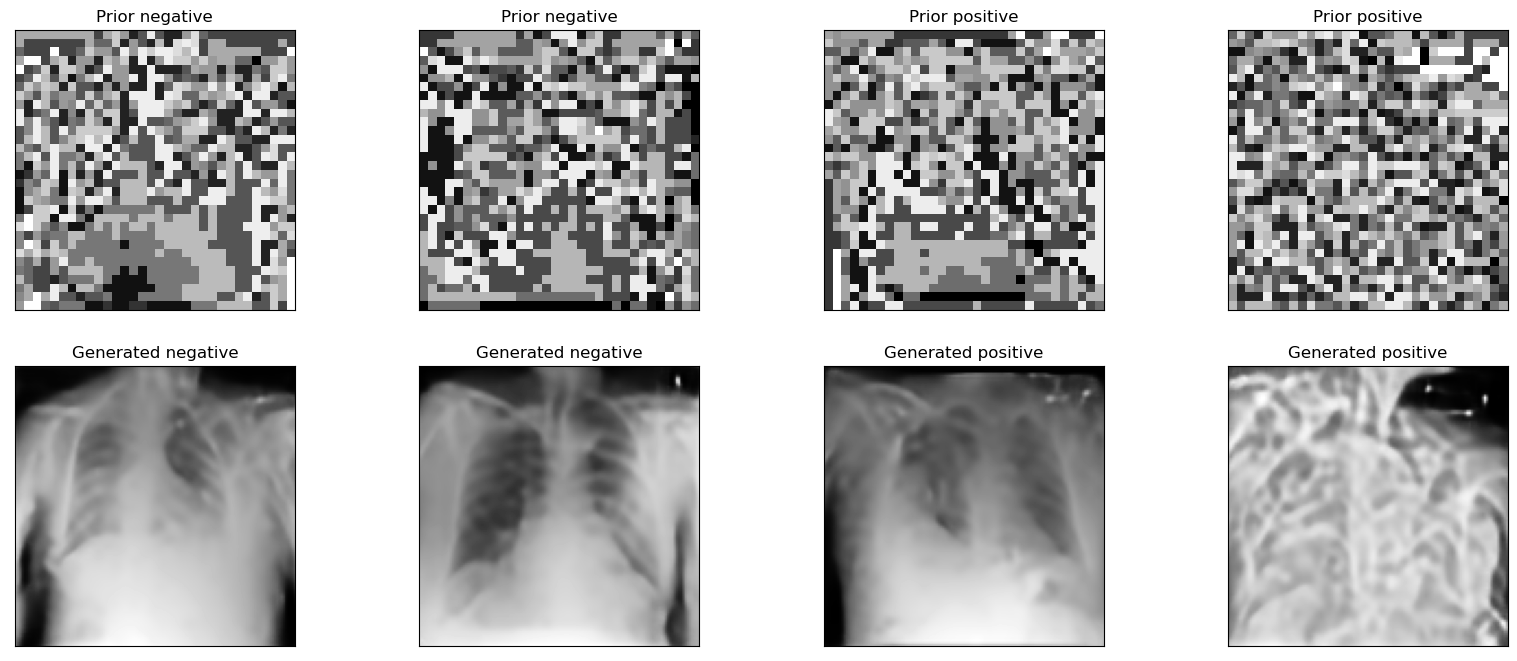

In [42]:
plt.figure(figsize=(20, 8))
for i in range(1, batch + 1):
    # Display priors
    ax = plt.subplot(2, batch, i)
    plt.imshow(priors[i-1], cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Prior {cond_inp_str[i-1]}")

    # Display generated_img
    ax = plt.subplot(2, batch, i + batch)
    plt.imshow(generated_samples[i-1], cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Generated {cond_inp_str[i-1]}")
plt.show()